In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [2]:
SEED = 1529

## Toy datasets

In [3]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 50, 2
    np.random.seed(0)
    C = np.array([[0., -0.1], [0.5, .1]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

linearly_separable = dataset_fixed_cov()

datasets = [make_moons(noise=0.1, random_state=SEED),
            make_circles(noise=0.1, factor=0.5, random_state=SEED),
            linearly_separable]

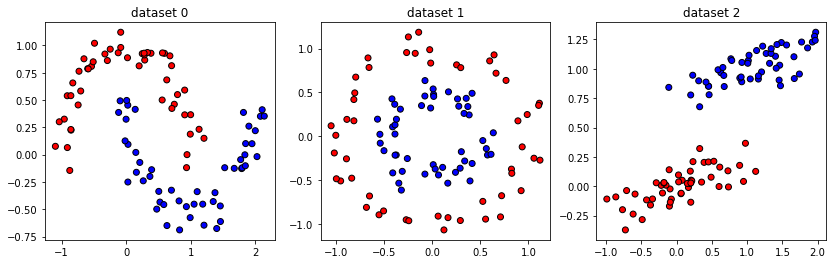

In [4]:
figure = plt.figure(figsize=(14,4))
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

for i in range(len(datasets)):
    plt.subplot(1, 3, i+1)
    plt.title(f'dataset {i}')
    plt.scatter(datasets[i][0][:,0], datasets[i][0][:,1], c=datasets[i][1], cmap=cm_bright, edgecolors='k')

## Closed-form solution

### Preprocessing the dataset

Number of points: 100
Dimension: 2


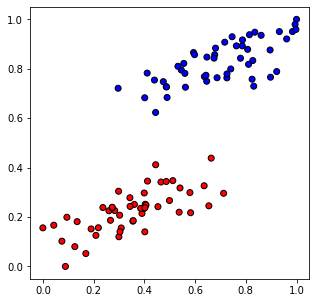

In [5]:
i = 2 # selects dataset
X, Y = datasets[i][0], datasets[i][1]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, cmap=cm_bright, edgecolors='k')

# Y[Y==0] = -1  # change labels to [-1,1]

l = len(Y)
d = len(X[0])
print("Number of points:", l)
print("Dimension:", d)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=SEED)

### SVM algorithm

Sections 6.2 (primal) and 6.3 (dual), taking V=I and no predicates.

In [6]:
class SVM():

    def __init__(self, C=1, kernel='rbf', gamma='auto'):
        self.C = C  # regularization param.
        self.kernel = kernel
        self.gamma = gamma  # for rbf kernel    
    
    
    def fit(self, X, Y):
        
        self.X = X          # data (scaled to [0,1])
        self.Y = Y          # labels 
        #self.Y[self.Y==0] = -1  # changing labels to {-1,1}
        self.l = len(Y)     # number of samples
        self.d = len(X[0])  # dimensionality 
        
        if self.gamma == 'auto':
            self.gamma = 1 / self.d # default gamma = 1 / n_features
  
        # K-matrix (Kernel)
        if self.kernel == 'linear':
            self.kernel = linear_kernel
            K = self.kernel(self.X, self.X)
        
        elif self.kernel == 'rbf':
            self.kernel = rbf_kernel
            K = self.kernel(self.X, self.X, self.gamma)

        I = np.eye(self.l)    # identity matrix 
        inv = np.linalg.inv(K + self.C*I)

        # Formulas (113), (114), (115)
        A_V = inv.dot(Y)
        A_C = inv.dot(np.ones(self.l))

        # Eq. 117
        a = np.ones(self.l).dot(K).dot(A_C) - np.ones(self.l).dot(np.ones(self.l)) 
        b = np.ones(self.l).dot(K).dot(A_V) - np.ones(self.l).dot(self.Y) 

        # solving system of linear eq.: obtaining c and mu
        self.c = b/a

        # constructing matrix A
        self.A = A_V - (self.c*A_C)
            
    
    def decision_function(self, X): 
        preds = []
        for x in X:
            preds.append(self.A.dot(self.kernel(self.X,[x])) + self.c)
        return np.array(preds).flatten()
    
    
    def predict(self, X): 
        preds = []
        for x in X:
            pred = self.A.dot(self.kernel(self.X,[x])) + self.c
            preds.append(1 if pred >= 0.5 else 0)
        return np.array(preds)
    
    
    def score(self, X, Y):
        pred = self.predict(X)
        return np.sum(pred == Y) / len(Y)
    
    
    def plot_boundaries(self, X_train, y_train, X_test, y_test):
        h = .02
        x_min, x_max = X_train[:, 0].min() - .2, X_train[:, 0].max() + .2
        y_min, y_max = X_train[:, 1].min() - .2, X_train[:, 1].max() + .2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        viz=np.c_[xx.ravel(),yy.ravel()]
        Z = self.decision_function(viz)
        Z = Z.reshape(xx.shape)
        
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        plt.figure(figsize=(5,5))
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cm_bright, edgecolors='k')
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
        plt.tight_layout()
        plt.show()

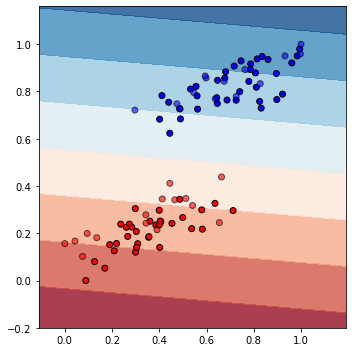

[-0.0679512   0.03924726  0.01081459  0.94007668  1.12297146  0.27826513
  0.14041909  0.27932365  1.17530416  0.79721239  1.01286385  0.84087397
  0.86502574  0.10941988  0.94957179 -0.00746351  0.25694223  0.12862186
  0.96006547  1.10489843  0.74370309  0.05738246  0.29159604  0.86438855
  0.139788    0.36592331  0.18503603  0.17731552  0.42384589  0.9442797 ]

Accuracy: 1.0


In [7]:
clf = SVM(C=1, kernel='linear')
clf.fit(X_train,y_train)
clf.plot_boundaries(X_train, y_train, X_test, y_test)

print(clf.decision_function(X_test))
print("\nAccuracy:", clf.score(X_test, y_test))

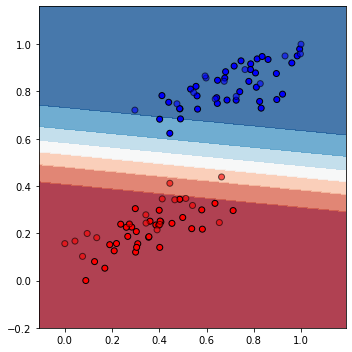

[-1.66850141 -1.34843852 -1.43661429  1.34269804  1.8982663  -0.62861291
 -1.03981173 -0.62318798  2.0533555   0.91096909  1.56205874  1.04725986
  1.11486359 -1.12959855  1.36750535 -1.4925981  -0.6862342  -1.07777507
  1.39841014  1.84192927  0.7448186  -1.29647189 -0.58482714  1.12073484
 -1.03916429 -0.36761886 -0.90770648 -0.91715339 -0.18663833  1.36172901]

Accuracy: 1.0


In [9]:
# SVC from sklearn

svm = SVC(C=1, kernel='linear', gamma=1/2, probability=True).fit(X_train,y_train)

h = .02
x_min, x_max = X_train[:, 0].min() - .2, X_train[:, 0].max() + .2
y_min, y_max = X_train[:, 1].min() - .2, X_train[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
viz=np.c_[xx.ravel(),yy.ravel()]
Z = svm.predict_proba(viz)[:,1]
Z = Z.reshape(xx.shape)

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cm_bright, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
plt.tight_layout()
plt.show()

print(svm.decision_function(X_test))
print("\nAccuracy:", svm.score(X_test, y_test))

In [103]:
#a1_c = 1 
#a1_mu = np.array([2,3])
#b1 = 11
#ak_c = np.array([4,7])
#ak_mu = np.array([[5,6],[8,9]])
#bk = np.array([22,33])

#a1 = np.concatenate(([a1_c], a1_mu))
#a2 = np.vstack(([ak_c],ak_mu.T)).T
#a = np.concatenate(([a1],a2), axis=0)
#b = np.concatenate(([b1], bk))
#a, b

### SVM with invariants

Section 6.2 (taking V=I) following the example in section 6.7.

In [9]:
class SVM_I(SVC):

    def __init__(self, C=1., kernel='rbf', gamma='auto', delta=10e-3, pred_nn=False):
        self.C = C  # regularization param.
        self.kernel = kernel
        self.gamma = gamma  # for rbf kernel 
        self.delta = delta  # T_s threshold (108)
        self.pred_nn = pred_nn
        
        
    def predicates_matrix(self, pred_nn=True, max_pred=10):

        if not pred_nn:   # using predicates based on 0th and 1st moments
            
            # 0th order moment
            phi = np.ones(self.l, dtype=int)
            Phi = [phi]

            # 1st order moments (1 for each dimension of the data)
            for k in range(self.d):
                Phi.append(np.array([self.X[i,k] for i in range(self.l)]))
        

        else:    # predicates based on local structure (See Example 3a, P.418)
            
            Phi = []
            for k in range(max_pred):
                neigh = NearestNeighbors(n_neighbors=k+2)
                neigh.fit(self.X)
                nn = neigh.kneighbors(self.X)[1][:,1:]
                self.nn = nn
                phi_k = np.array([sum(self.Y[k]) for k in nn])
                Phi.append(phi_k)
            
        #Phi = []
        # Features with low p-value
        # phi = np.array([(self.X[i,2] + self.X[i,4] + self.X[i,8]) for i in range(self.l)])  # -> 0.66516 AUC
        # phi = np.array([(self.X[i,2]>0 and self.X[i,4]>0 and self.X[i,8]>0) for i in range(self.l)]) # -> 0.67722 AUC (region)
        # Phi.append(phi)  # region
        
        # sum of GRS
        # phi = np.array([(self.X[i,3] + self.X[i,4] + self.X[i,5] + self.X[i,6]) for i in range(self.l)]) # -> 0.66516 AUC
        # Region + GRS -> 0.672869 AUC
        
        # GRS == 0 -> 0.69836 AUC
        phi = np.array([(self.X[i,3]==0 and self.X[i,4]==0 and self.X[i,5]==0 and self.X[i,6]==0) for i in range(self.l)])
        Phi.append(phi)  
        # and features with low p-value -> 0.7148356 AUC
        phi = np.array([(self.X[i,2]==0 and self.X[i,8]==0) for i in range(self.l)])
        Phi.append(phi) 
        # and the rest -> 0.686127 AUC
        # phi = np.array([(self.X[i,0]==0 and self.X[i,1]==0 and self.X[i,7]==0) for i in range(self.l)])
        # Phi.append(phi)  
        # region + grs==0 + low p-value==0 -> 0.705806 AUC
 
            
        # predicates matrix
        return np.array(Phi)
            
    
    def fit(self, X, Y):        
        
        self.X = X.copy()          # data (scaled to [0,1])
        self.Y = Y.copy()          # labels 
        # self.Y[self.Y==0] = -1   # change labels to [-1,1]
        self.l = len(Y)            # number of samples
        self.d = len(X[0])         # dimensionality 
        self.classes_ = np.unique(Y)
  
        if self.gamma == 'auto':
            self.gamma = 1 / self.d # default gamma = 1 / n_features
  
        # K-matrix (Kernel)
        if self.kernel == 'linear':
            self.kernel_f = linear_kernel
            self.K = self.kernel_f(self.X, self.X)
        
        elif self.kernel == 'rbf':
            self.kernel_f = rbf_kernel
            self.K = self.kernel_f(self.X, self.X, self.gamma)
        
        # predicates
        predicates = self.predicates_matrix(pred_nn=self.pred_nn)
        self.m = 0   # current number of active predicates
        
        I = np.eye(self.l)    # identity matrix 
        inv = np.linalg.inv(self.K + self.C*I)
        
        # Initial sol. (SVM)
        A_V = inv.dot(Y)
        A_C = inv.dot(np.ones(self.l))

        a = np.ones(self.l).dot(self.K).dot(A_C) - self.l
        b = np.ones(self.l).dot(self.K).dot(A_V) - np.ones(self.l).dot(self.Y) 
        
        self.c = b/a
        self.A = A_V - self.c*A_C
        
        if self.d == 2:
            self.plot_boundaries(X, Y, X, Y)

        
        # adding invariants iteratively
        Phi = []
        T_max = 1 + self.delta
        
        # iterate over predicates finding the one with maximal disagreement T
        while T_max > self.delta and len(predicates) > 0:
            T = []
            for k in range(len(predicates)):
                num = predicates[k].dot(self.K).dot(self.A) + self.c*(predicates[k].dot(np.ones(self.l))) - predicates[k].dot(Y)
                den = Y.dot(predicates[k])
                T.append(abs(num) / den)
            
            self.T = T ### debug    
            T_max = max(T)

            if T_max > self.delta:
                self.m += 1
                if type(Phi) == list:
                    Phi.append(predicates[np.argmax(T)])
                    Phi = np.array(Phi)
                else:
                    Phi = np.concatenate([Phi, [predicates[np.argmax(T)]]])
                    
                predicates = np.delete(predicates, (np.argmax(T)), axis=0)


                # Formulas (113), (114), (115)
                # A_V = inv.dot(Y)
                # A_C = inv.dot(np.ones(self.l))
                A_S = np.array([inv.dot(Phi[s]) for s in range(self.m)])

                # Eq. 117
                a1_c = np.ones(self.l).dot(self.K).dot(A_C) - self.l 
                a1_mu = np.array([np.ones(self.l).dot(self.K).dot(A_S[s]) - np.ones(self.l).dot(Phi[s]) for s in range(self.m)])
                b1 = np.ones(self.l).dot(self.K).dot(A_V) - np.ones(self.l).dot(self.Y) 

                # Eq. 118
                ak_c = np.array([A_C.dot(self.K).dot(Phi[k]) - np.ones(self.l).dot(Phi[k]) for k in range(self.m)])
                ak_mu = np.array([np.array([A_S[s].dot(self.K).dot(Phi[k]) for s in range(self.m)]) for k in range(self.m)])
                bk = np.array([A_V.dot(self.K).dot(Phi[k]) - Y.dot(Phi[k]) for k in range(self.m)])

                # creating system of linear equations
                a1 = np.concatenate(([a1_c], a1_mu))
                a2 = np.vstack(([ak_c],ak_mu.T)).T
                a = np.concatenate(([a1],a2), axis=0)
                b = np.concatenate(([b1], bk))

                # obtaining c and mu
                sol = np.linalg.solve(a,b)
                self.c = sol[0]
                self.mu = sol[1:]

                # constructing matrix A
                self.A = A_V - self.c*A_C - np.sum(np.array([self.mu[s]*A_S[s] for s in range(self.m)]), axis=0)

                ########## DEBUG
                self.Phi = Phi
                ##########
                
                if self.d == 2:
                    self.plot_boundaries(X, Y, X, Y)
        
        return self
    
    
    def decision_function(self, X): 
        preds = []
        for x in X:
            preds.append(self.A.dot(self.kernel_f(self.X,[x])) + self.c)
        return np.array(preds).flatten()
    
    
    def predict(self, X): 
        preds = []
        for x in X:
            pred = self.A.dot(self.kernel_f(self.X,[x])) + self.c
            preds.append(1 if pred >= 0.5 else 0)
        return np.array(preds)
    
    
    def score(self, X, Y):
        preds = self.predict(X)
        return np.sum(preds == Y) / len(Y)
    
    
    def plot_boundaries(self, X_train, y_train, X_test, y_test):
        h = .02
        x_min, x_max = X_train[:, 0].min() - .2, X_train[:, 0].max() + .2
        y_min, y_max = X_train[:, 1].min() - .2, X_train[:, 1].max() + .2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        viz=np.c_[xx.ravel(),yy.ravel()]
        Z = self.decision_function(viz)
        Z = Z.reshape(xx.shape)
        
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        plt.figure(figsize=(5,5))
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)  # add 0.5
        plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cm_bright, edgecolors='k')
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
        plt.tight_layout()
        plt.title(f"Classification boundaries with {self.m} invariants")
        plt.show()

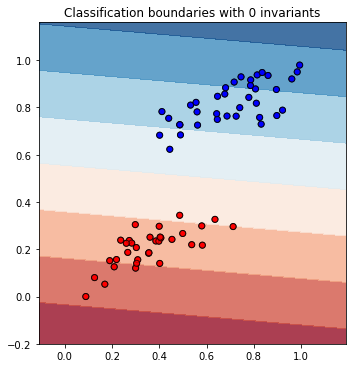

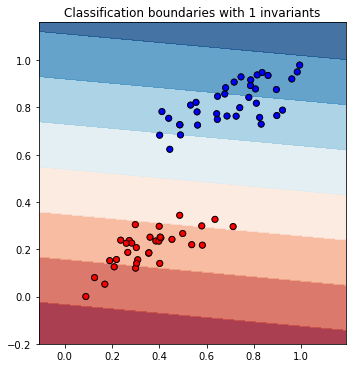

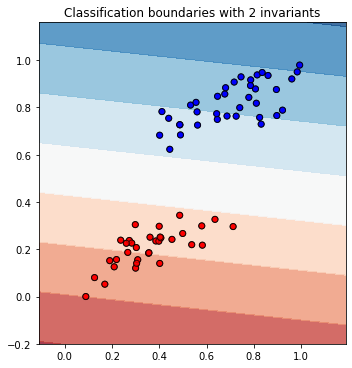

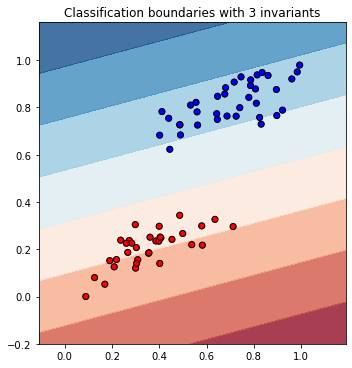

SVM_I(C=1, gamma=0.5, kernel=<function linear_kernel at 0x0000014322ED1C10>)

In [21]:
######### using labels -> 0, 1

clf = SVM_I(C=1, kernel='linear')
clf.fit(X_train,y_train)

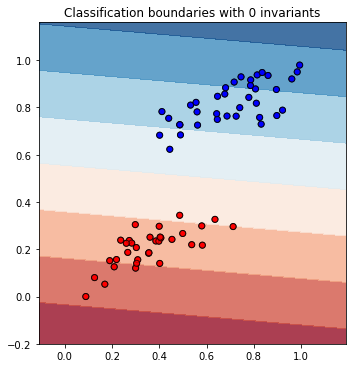

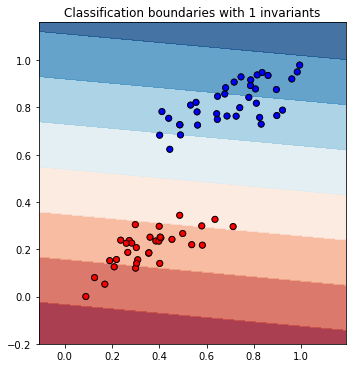

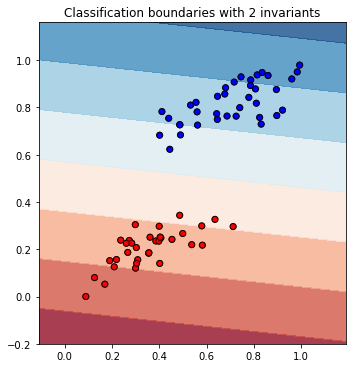

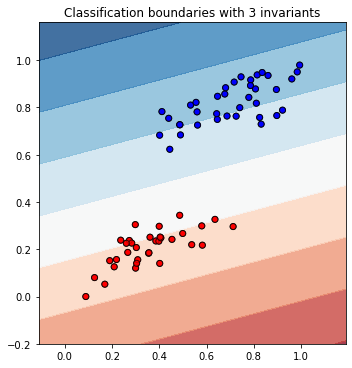

SVM_I(C=1, gamma=0.5, kernel=<function linear_kernel at 0x00000242F1792C10>)

In [195]:
######### using labels -> -1, 1

clf = SVM_I(C=1, kernel='linear')
clf.fit(X_train,y_train)

In [22]:
clf.T

[0.02797935290182695]

In [23]:
clf.Phi.shape

(3, 70)

In [24]:
clf.decision_function(X_test)

array([-0.0258519 ,  0.08907598,  0.10777758,  1.03199833,  1.08582996,
        0.2526417 ,  0.09933544,  0.21986343,  1.15931944,  0.95638569,
        1.07948633,  0.91438446,  1.0077641 ,  0.02465259,  1.09522756,
        0.10930987,  0.13928752,  0.12772631,  1.11286122,  1.10204153,
        0.99467797,  0.14116227,  0.20727501,  0.89066179,  0.06074401,
        0.35751299,  0.16375876, -0.04825599,  0.29919199,  0.9394298 ])

In [25]:
pred = clf.predict(X_test)
pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1])

In [26]:
y_test

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [27]:
clf.score(X_test, y_test)

1.0

## Comparison with sklearn models

In [28]:
from sklearn.svm import SVC

svm = SVC(C=1, gamma='auto', probability=True).fit(X_train,y_train)
svm.score(X_test, y_test)

1.0

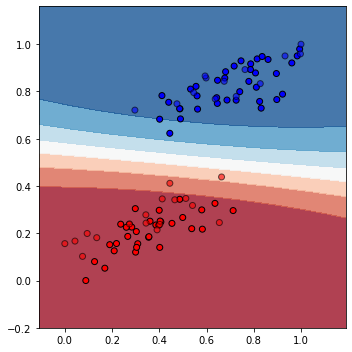

In [29]:
h = .02
x_min, x_max = X_train[:, 0].min() - .2, X_train[:, 0].max() + .2
y_min, y_max = X_train[:, 1].min() - .2, X_train[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
viz=np.c_[xx.ravel(),yy.ravel()]
Z = svm.predict_proba(viz)[:,1]
Z = Z.reshape(xx.shape)

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cm_bright, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
plt.tight_layout()
plt.show()

# Testing SVM&I in our data

In [3]:
import pandas as pd

path = '../data/'
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','excluido','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [4]:
y.value_counts() 

0    318
1     73
Name: VTE, dtype: int64

In [5]:
#### scale to [0,1]
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

#### labels {-1,1}
y = y.to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [7]:
%load_ext autoreload
%autoreload 2
from utils import *  ## delete from this folder 

In [107]:
# default predicates

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 312 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done 718 tasks      | elapsed:   31.2s
[Parallel(n_jobs=2)]: Done 1284 tasks      | elapsed:   55.6s
[Parallel(n_jobs=2)]: Done 2014 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 2904 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 3958 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 5172 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 6550 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 8088 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done 9790 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 11652 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 13678 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done 15864 tasks      | elapsed: 12.9min
[Parallel(n_jobs=2)]: Done 18214 tasks      | elapsed: 15

{'SVM_I__C': 942.6684551178854,
 'SVM_I__gamma': 0.6,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

In [108]:
gs_svm_I.best_score_

0.679540790610599

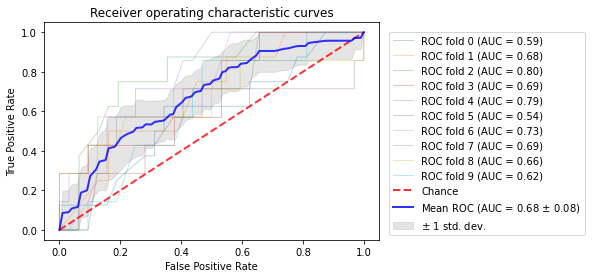

,score,mean,95% CI
0,AUC,0.68,"(0.52,0.84)"
1,accuracy,0.73,"(0.68,0.77)"
2,sensitivity,0.40,"(0.09,0.71)"
3,specificity,0.81,"(0.77,0.84)"
4,PPV,0.31,"(0.15,0.47)"
5,NPV,0.86,"(0.79,0.92)"


In [109]:
test_model(gs_svm_I.best_estimator_, X, y)

In [114]:
# using custom predicates (region)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:   43.6s
[Parallel(n_jobs=2)]: Done 1322 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 2454 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 3914 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 5694 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 7802 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done 10230 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done 12986 tasks      | elapsed: 11.7min
[Parallel(n_jobs=2)]: Done 16062 tasks      | elapsed: 14.8min
[Parallel(n_jobs=2)]: Done 19466 tasks      | elapsed: 18.2min
[Parallel(n_jobs=2)]: Done 20800 out of 20800 | elapsed: 19.6min finished


{'SVM_I__C': 0.0027283333764867696,
 'SVM_I__gamma': 1,
 'SVM_I__kernel': 'linear',
 'SVM_I__pred_nn': False}

In [115]:
gs_svm_I.best_score_

0.6772222422235024

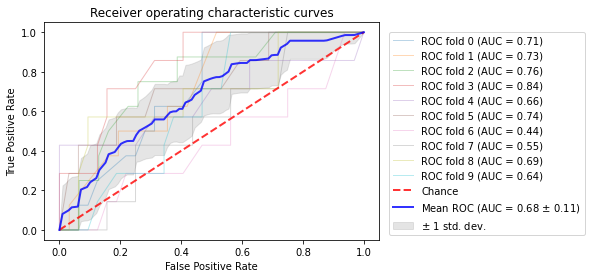

,score,mean,95% CI
0,AUC,0.68,"(0.46,0.89)"
1,accuracy,0.73,"(0.67,0.79)"
2,sensitivity,0.39,"(0,0.8)"
3,specificity,0.81,"(0.76,0.85)"
4,PPV,0.30,"(0.04,0.55)"
5,NPV,0.86,"(0.78,0.93)"


In [116]:
test_model(gs_svm_I.best_estimator_, X, y)

In [131]:
# using custom predicates (GRS == 0)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:   36.3s
[Parallel(n_jobs=2)]: Done 1322 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 2454 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done 3914 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 5694 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 7802 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 9138 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 10516 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 12054 tasks      | elapsed: 11.9min
[Parallel(n_jobs=2)]: Done 13756 tasks      | elapsed: 13.7min
[Parallel(n_jobs=2)]: Done 15618 tasks      | elapsed: 15.6min
[Parallel(n_jobs=2)]: Done 17644 tasks      | elapsed: 17.8min
[Parallel(n_jobs=2)]: Done 19830 tasks      | elapsed: 20.1min
[Parallel(n_jobs=2)]: Done 20800 out of 20800 | elaps

{'SVM_I__C': 55.41020330009492,
 'SVM_I__gamma': 0.5,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

In [132]:
gs_svm_I.best_score_

0.6983609951036867

<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-130-890d02b9cade>:101: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num)

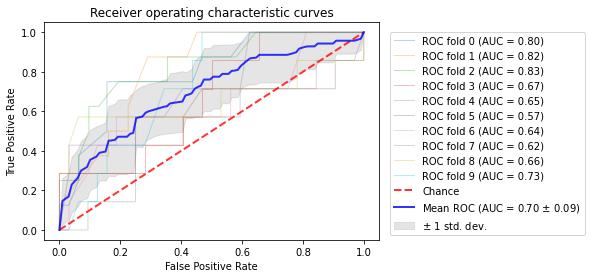

,score,mean,95% CI
0,AUC,0.70,"(0.53,0.87)"
1,accuracy,0.74,"(0.69,0.8)"
2,sensitivity,0.46,"(0.08,0.83)"
3,specificity,0.80,"(0.77,0.84)"
4,PPV,0.34,"(0.15,0.53)"
5,NPV,0.87,"(0.8,0.94)"


In [134]:
test_model(gs_svm_I.best_estimator_, X, y)

In [136]:
# using custom predicates (GRS & p-value == 0)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 232 tasks      | elapsed:   33.1s
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:   57.1s
[Parallel(n_jobs=2)]: Done 1076 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1806 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 2696 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 3750 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done 4910 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done 6288 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done 7768 tasks      | elapsed: 10.1min
[Parallel(n_jobs=2)]: Done 9470 tasks      | elapsed: 12.4min
[Parallel(n_jobs=2)]: Done 10522 tasks      | elapsed: 15.6min
[Parallel(n_jobs=2)]: Done 11803 tasks      | elapsed: 18.6min
[Parallel(n_jobs=2)]: Done 12896 tasks      | elapsed: 21.1min
[Parallel(n_jobs=2)]: Done 14071 tasks      | elapsed: 22

{'SVM_I__C': 942.6684551178854,
 'SVM_I__gamma': 0.5,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

In [137]:
gs_svm_I.best_score_

0.7148356494815667

<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
<ipython-input-135-be40998087f3>:108: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num)

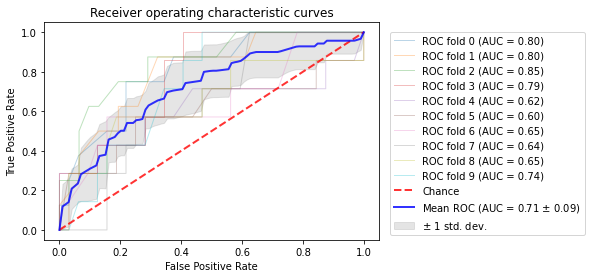

,score,mean,95% CI
0,AUC,0.71,"(0.54,0.89)"
1,accuracy,0.74,"(0.68,0.8)"
2,sensitivity,0.46,"(0.2,0.72)"
3,specificity,0.81,"(0.77,0.84)"
4,PPV,0.35,"(0.2,0.5)"
5,NPV,0.87,"(0.82,0.92)"


In [138]:
test_model(gs_svm_I.best_estimator_, X, y)

## Results

|            Model            |      AUC     | accuracy | sensitivity | specificity |  PPV |  NPV |
|:---------------------------:|:------------:|:--------:|:-----------:|:-----------:|:----:|:----:|
|        Logistic Regression        | 0.69 +- 0.07 |   0.71   |     0.36    |     0.79    | 0.27 | 0.85 |
|          Linear SVC         | 0.69 +- 0.07 |   0.71   |     0.36    |     0.79    | 0.27 | 0.85 |
|             KNN             | 0.70 +- 0.05 |   0.73   |     0.38    |     0.81    | 0.32 | 0.85 |
|             SVC             | 0.57 +- 0.16 |   0.69   |     0.22    |     0.80    | 0.18 | 0.82 |
|         Bagging (LR)        | 0.70 +- 0.07 |   0.71   |     0.37    |     0.79    | 0.27 | 0.85 |
|        Bagging (KNN)        | 0.68 +- 0.05 |   0.73   |     0.32    |     **0.82**    | 0.28 | 0.84 |
|        Random Forest        | 0.66 +- 0.10 |   0.71   |     0.36    |     0.79    | 0.28 | 0.85 |
|         Extra Trees         | 0.65 +- 0.09 |   0.71   |     0.29    |     0.80    | 0.24 | 0.83 |
|           AdaBoost          | 0.66 +- 0.10 |   0.73   |     0.36    |     0.81    | 0.28 | 0.85 |
|        Grad. Boosting       | 0.66 +- 0.07 |   0.71   |     0.29    |     0.81    | 0.25 | 0.83 |
| Voting  (LR+KNN+bagging_lr) | 0.70 +- 0.06 |   0.72   |     0.38    |     0.80    | 0.29 | 0.85 |
|  Stacking  (KNN+bagging_lr) | 0.70 +- 0.05 |  0.73   |     0.34    |    **0.82**    | 0.30 | 0.85 |
|   LUSI (default predicates) | 0.68 +- 0.08 |    0.73     | 0.40 | 0.81 | 0.31 | 0.86 |
|   LUSI (pred. v1)  | 0.70 +- 0.09 |    **0.74**     | **0.46** | 0.80 | 0.34 | **0.87** |
|   **LUSI (pred. v2)**  | **0.71 +- 0.09** |    **0.74**     | **0.46** | 0.81 | **0.35** | **0.87** |